In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 663kB/s]
100% 593k/593k [00:00<00:00, 663kB/s]


In [ ]:
!unzip nlp-getting-started.zip


Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# Load Libraries

In [ ]:
# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches



# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 93.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/spacy/util.py:918: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn_msg)


# Load data

In [ ]:
# Loading the train and test data for visualization & exploration.

trainv = pd.read_csv('train.csv')
testv = pd.read_csv('test.csv')

In [ ]:
# Taking general look at the both datasets.

display(trainv.sample(5))
display(testv.sample(5))

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


,id,keyword,location,text
142,449,armageddon,1996???????????,UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm
2672,8915,snowstorm,Los Angeles,@BigBang_CBS ...wow...ok...um...that was like ...
2605,8682,sinkhole,"New York, New York",The sinkhole that ate Brooklyn http://t.co/28r...
2515,8381,ruin,"Monroe, OH",Don't ruin a good today by thinking about a ba...
958,3187,deluge,"West Powelton, Philadelphia",I'm havin previous life flashbacks of when i l...


In [ ]:
# Checking observation and feature numbers for train and test data.

print(trainv.shape)
print(testv.shape)

(7613, 5)
(3263, 4)


# Preprocessing

In [ ]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

trainv['text_clean'] = trainv['text'].apply(lambda x: remove_URL(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_emoji(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_html(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_punct(x))

In [ ]:
# Tokenizing the tweet base texts.

trainv['tokenized'] = trainv['text_clean'].apply(word_tokenize)

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [ ]:
# Lower casing clean text.

trainv['lower'] = trainv['tokenized'].apply(
    lambda x: [word.lower() for word in x])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala..."


In [ ]:
# Removing stopwords.

trainv['stopwords_removed'] = trainv['lower'].apply(
    lambda x: [word for word in x if word not in stop])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [ ]:
# Applying part of speech tags.

trainv['pos_tags'] = trainv['stopwords_removed'].apply(nltk.tag.pos_tag)

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [ ]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


trainv['wordnet_pos'] = trainv['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


In [ ]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

trainv['lemmatized'] = trainv['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

trainv['lemmatized'] = trainv['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

trainv['lemma_str'] = [' '.join(map(str, l)) for l in trainv['lemmatized']]

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


# Visualizing the Data

## Target Distribution

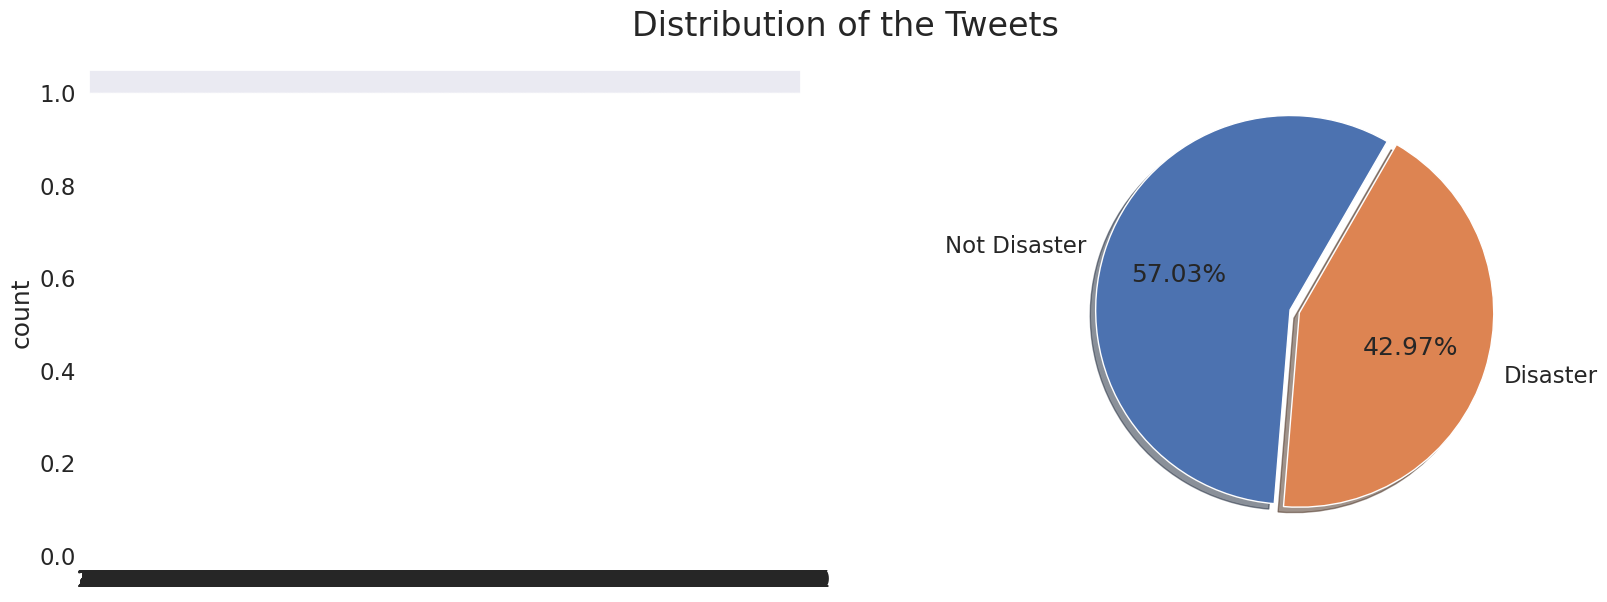

In [ ]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(trainv['target'], ax=axes[0])
axes[1].pie(trainv['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

## Tweet Lengths

In [ ]:
#Creating a new feature for the visualization.

trainv['Character Count'] = trainv['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

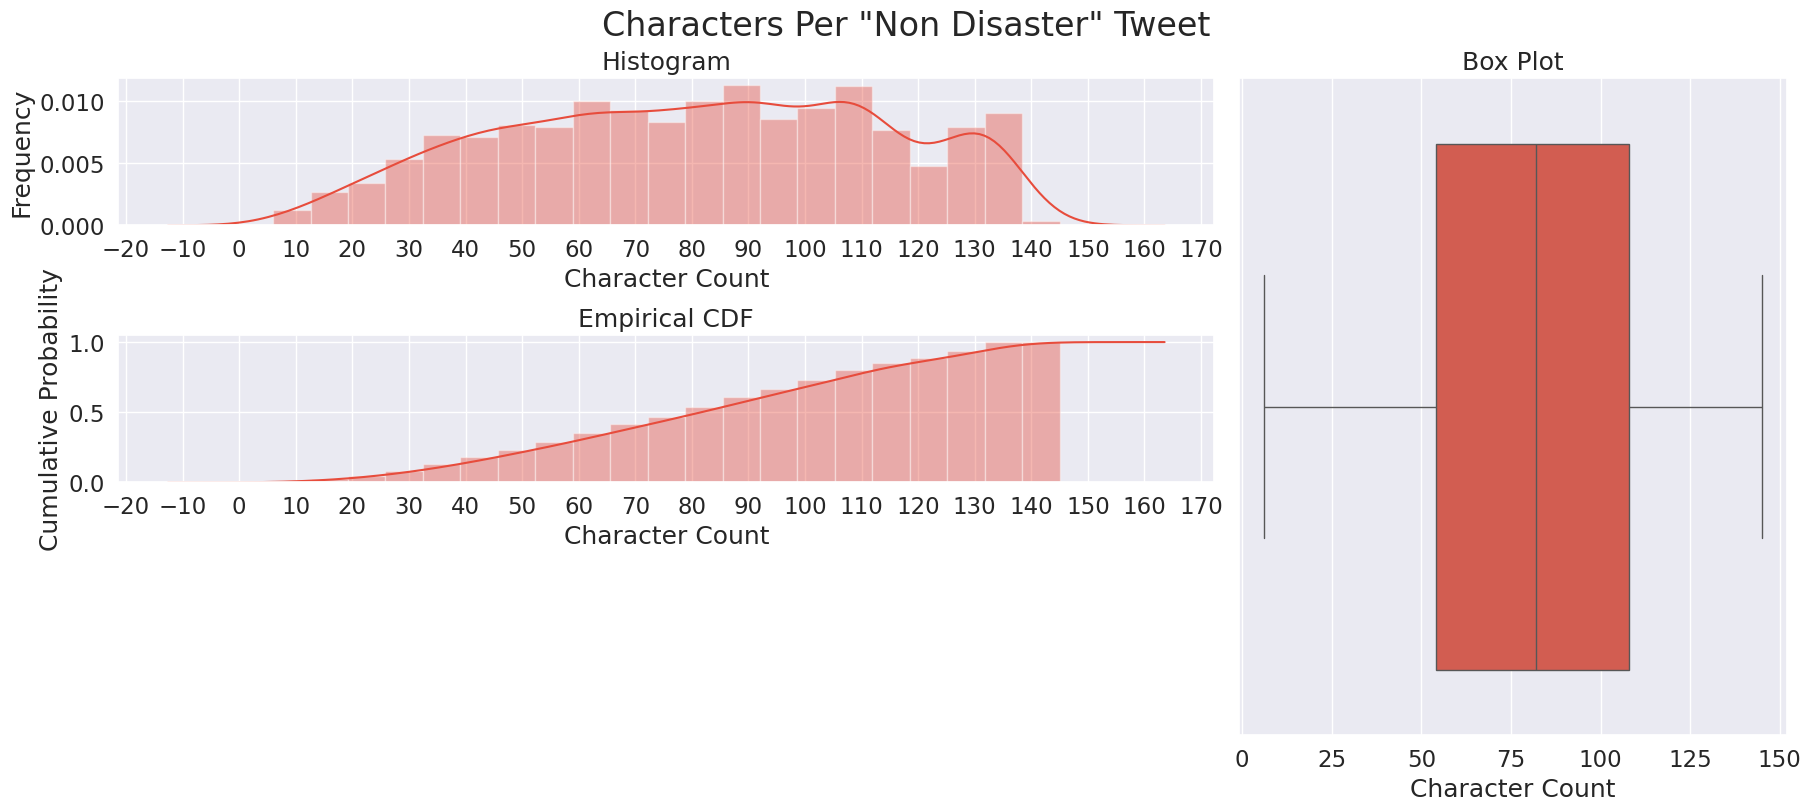

In [ ]:
plot_dist3(trainv[trainv['target'] == 0], 'Character Count',
           'Characters Per "Non Disaster" Tweet')

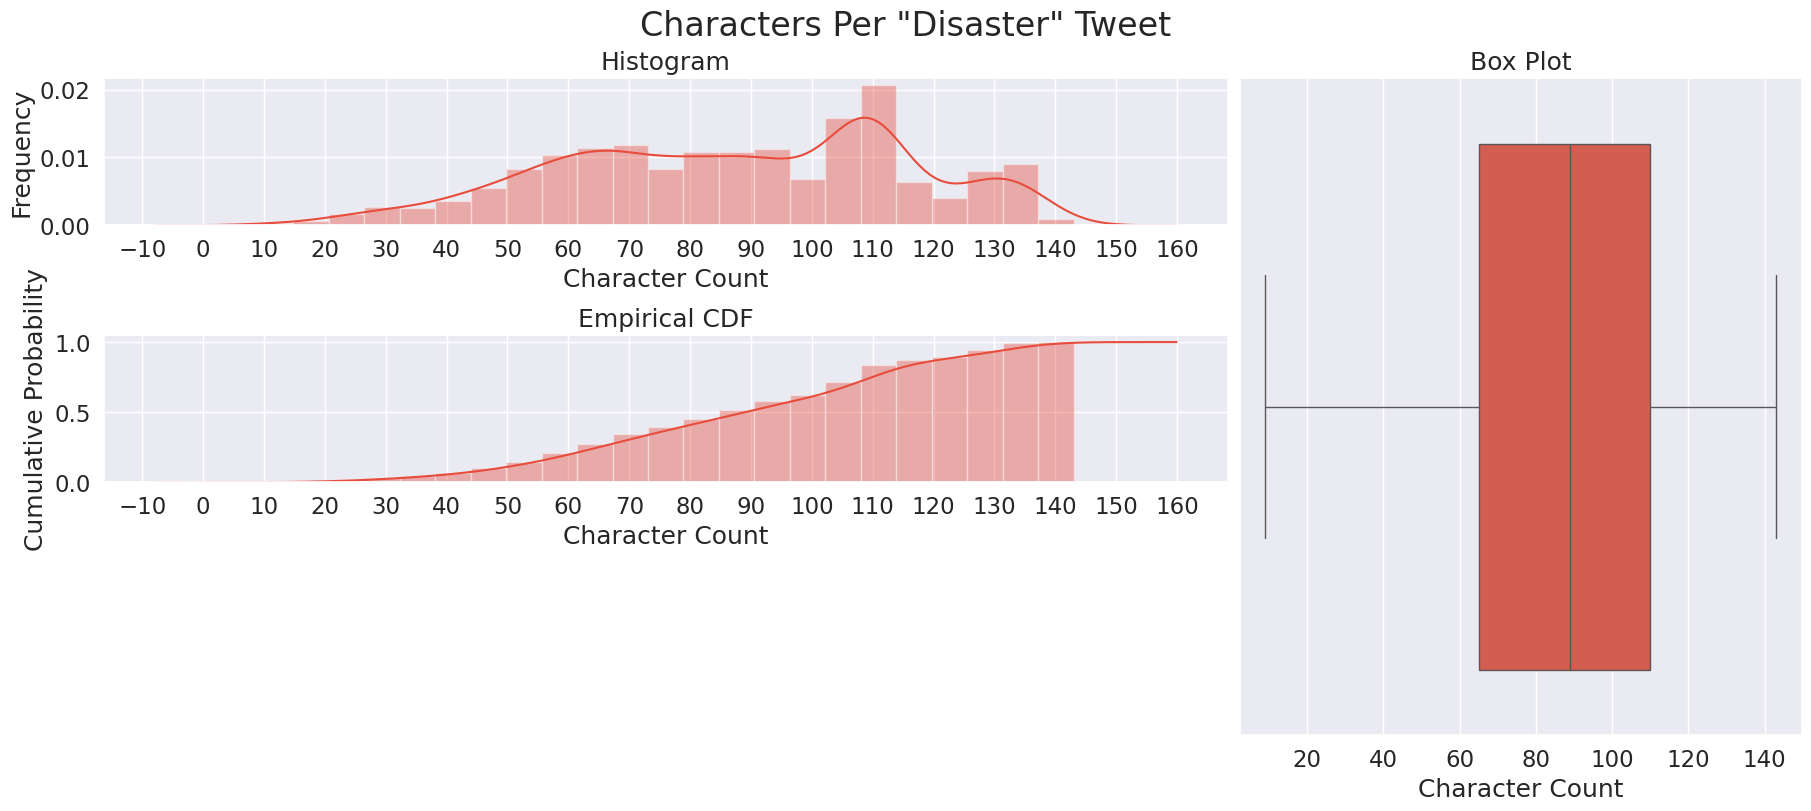

In [ ]:
plot_dist3(trainv[trainv['target'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

## Word Counts


In [ ]:
def plot_word_number_histogram(textno, textye):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')

    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')

    fig.tight_layout()


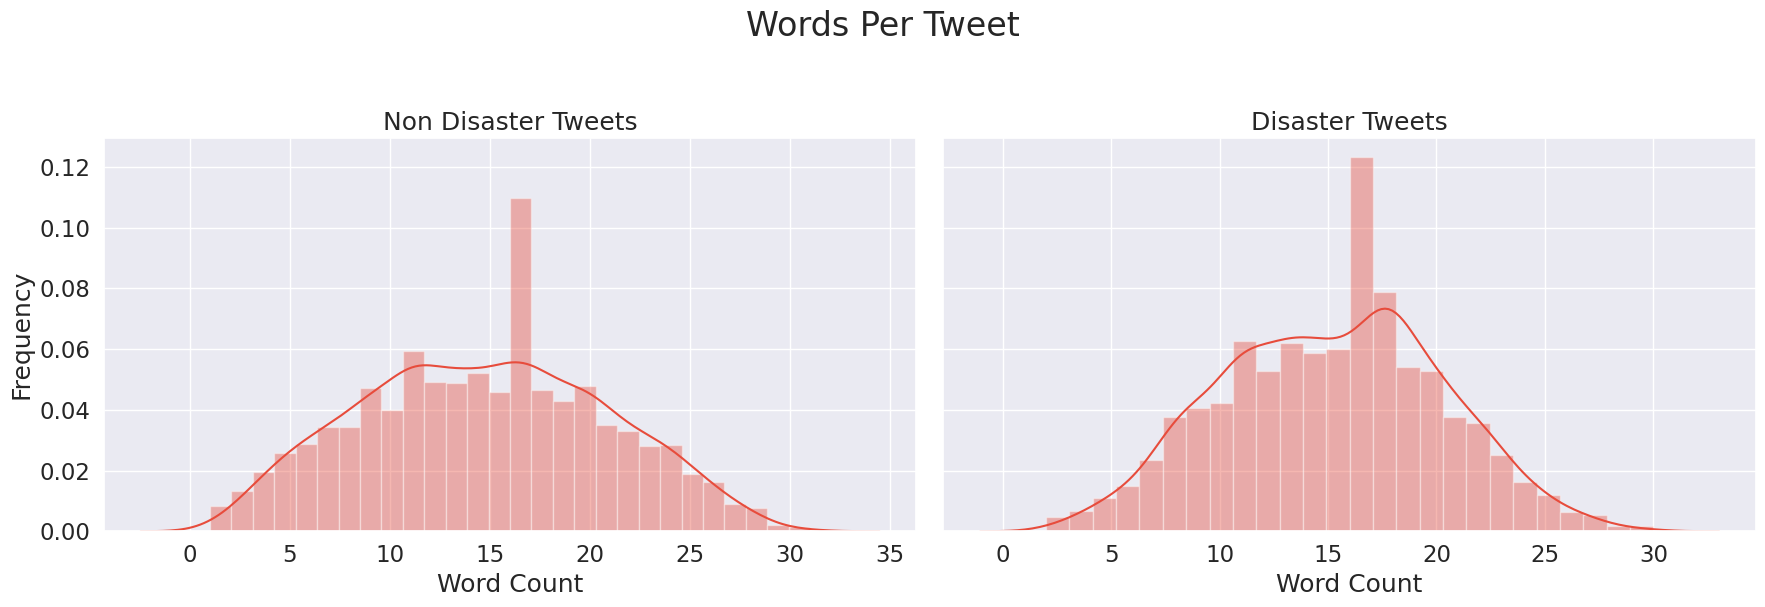

In [ ]:
plot_word_number_histogram(trainv[trainv['target'] == 0]['text'],
                           trainv[trainv['target'] == 1]['text'])

## Word Lengths


In [ ]:
def plot_word_len_histogram(textno, textye):

    """A function for comparing average word length"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')

    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()


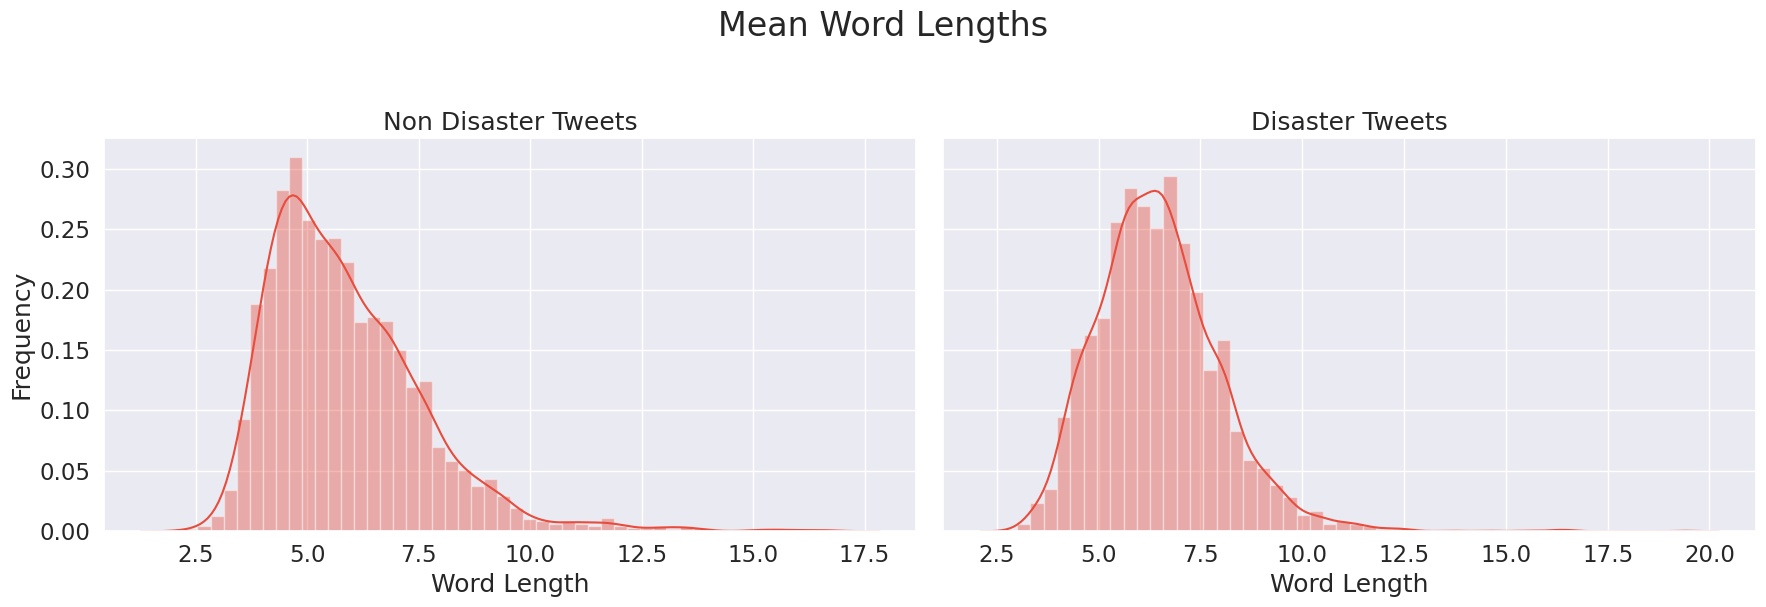

In [ ]:
plot_word_len_histogram(trainv[trainv['target'] == 0]['text'],
                        trainv[trainv['target'] == 1]['text'])

In [ ]:
lis = [
    trainv[trainv['target'] == 0]['lemma_str'],
    trainv[trainv['target'] == 1]['lemma_str']
]


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df = pd.DataFrame([x, y]).T
        df = df.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


## Most Common Words


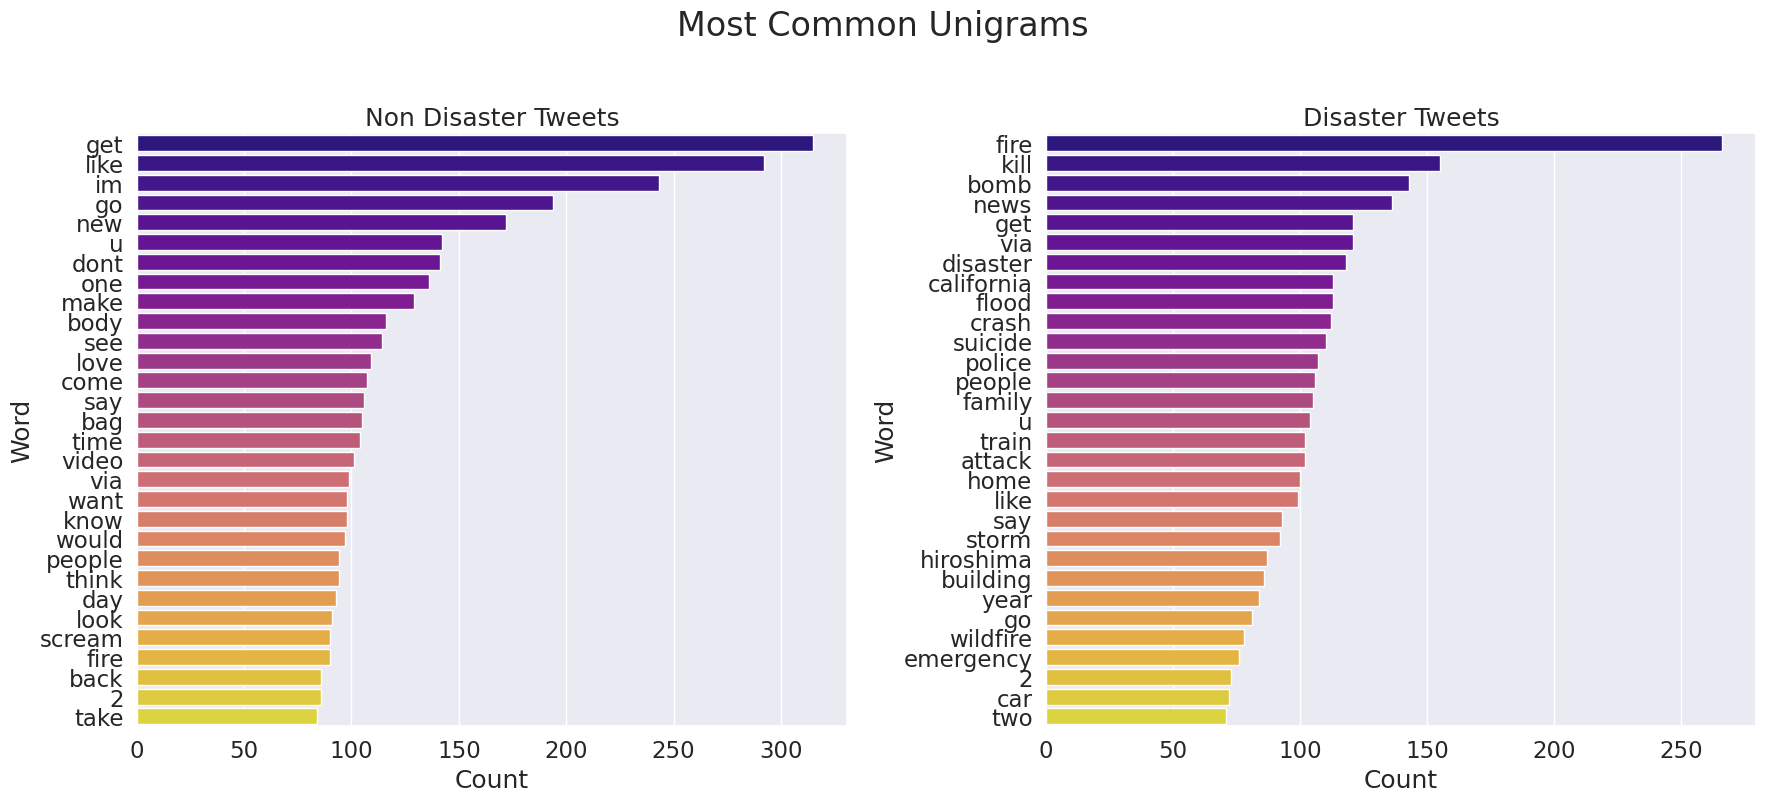

In [ ]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [ ]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)

        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

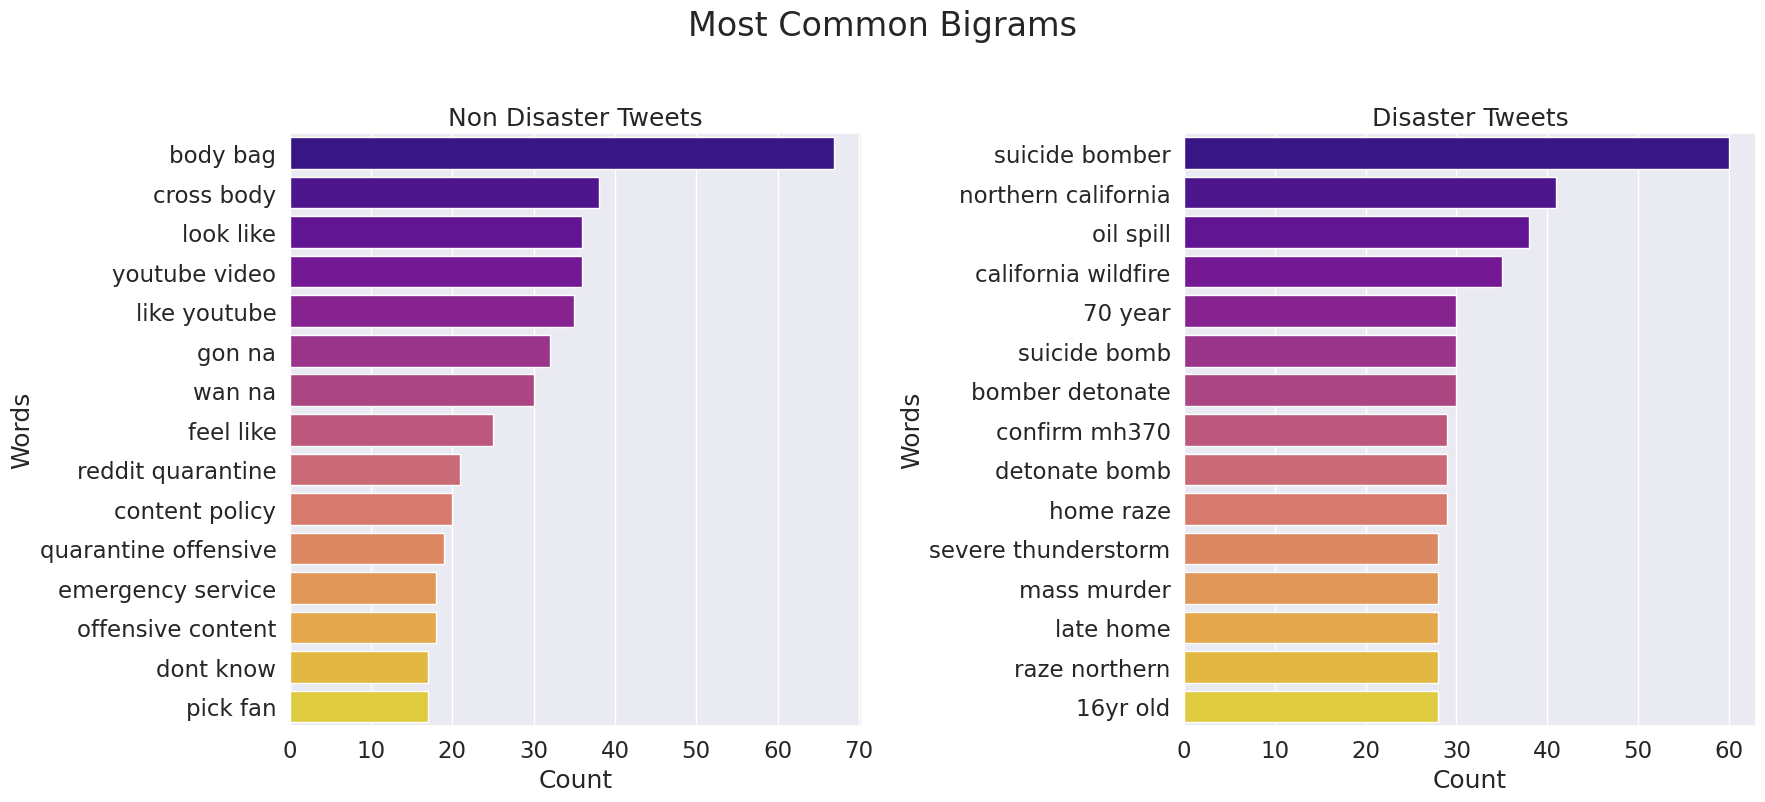

In [ ]:
ngrams(2, 'Most Common Bigrams')


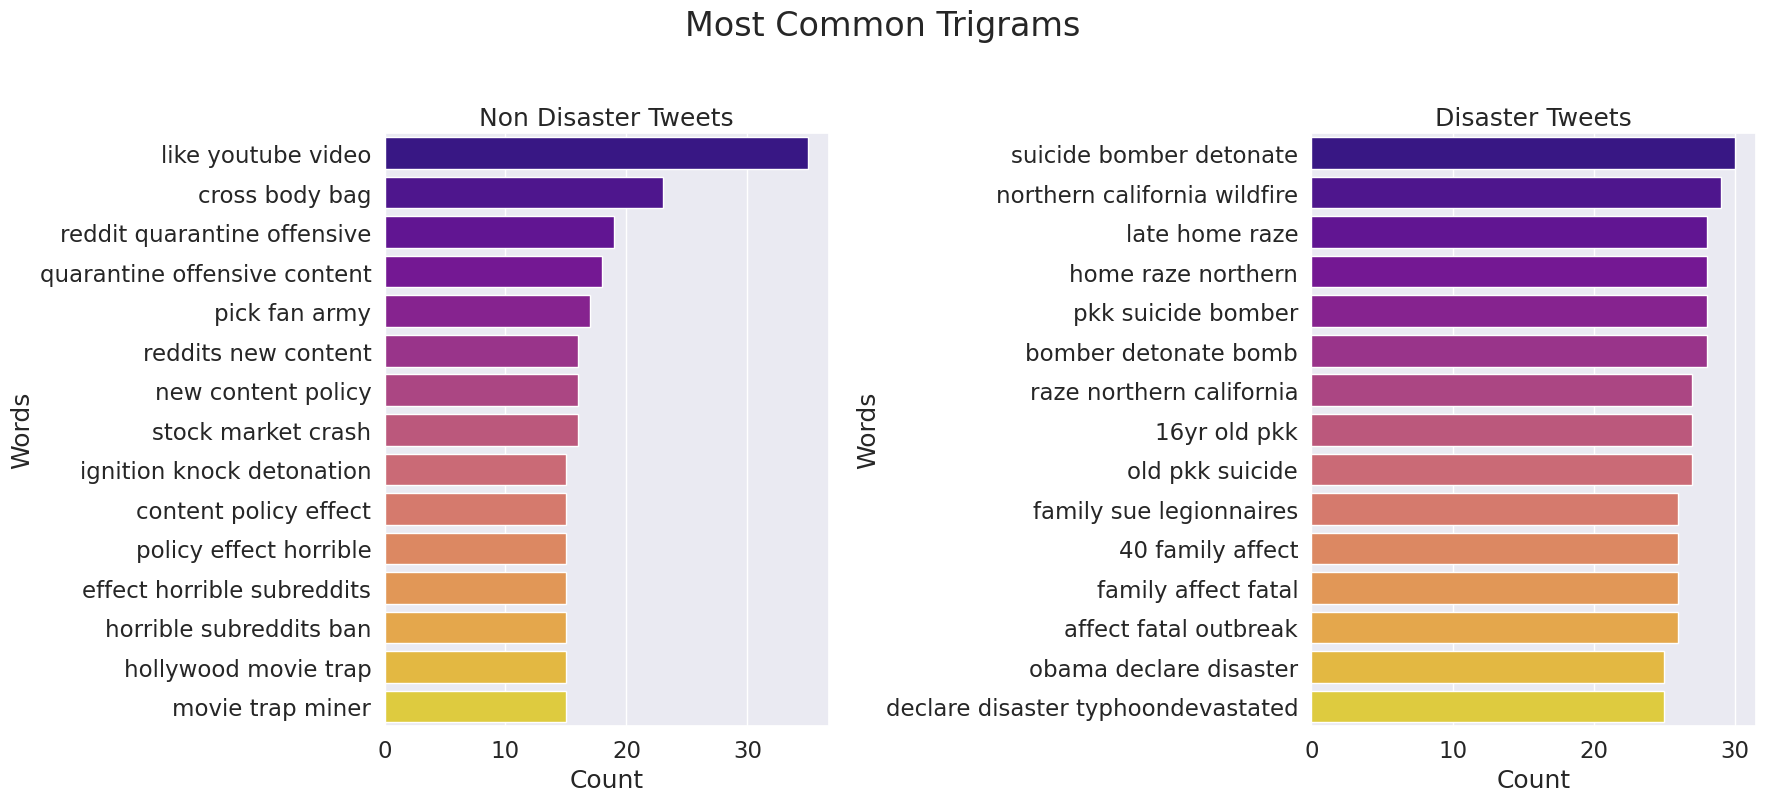

In [ ]:
ngrams(3, 'Most Common Trigrams')


In [ ]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        contour_width=0.1,
        contour_color='grey',
    ).generate(str(mostcommon))

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()

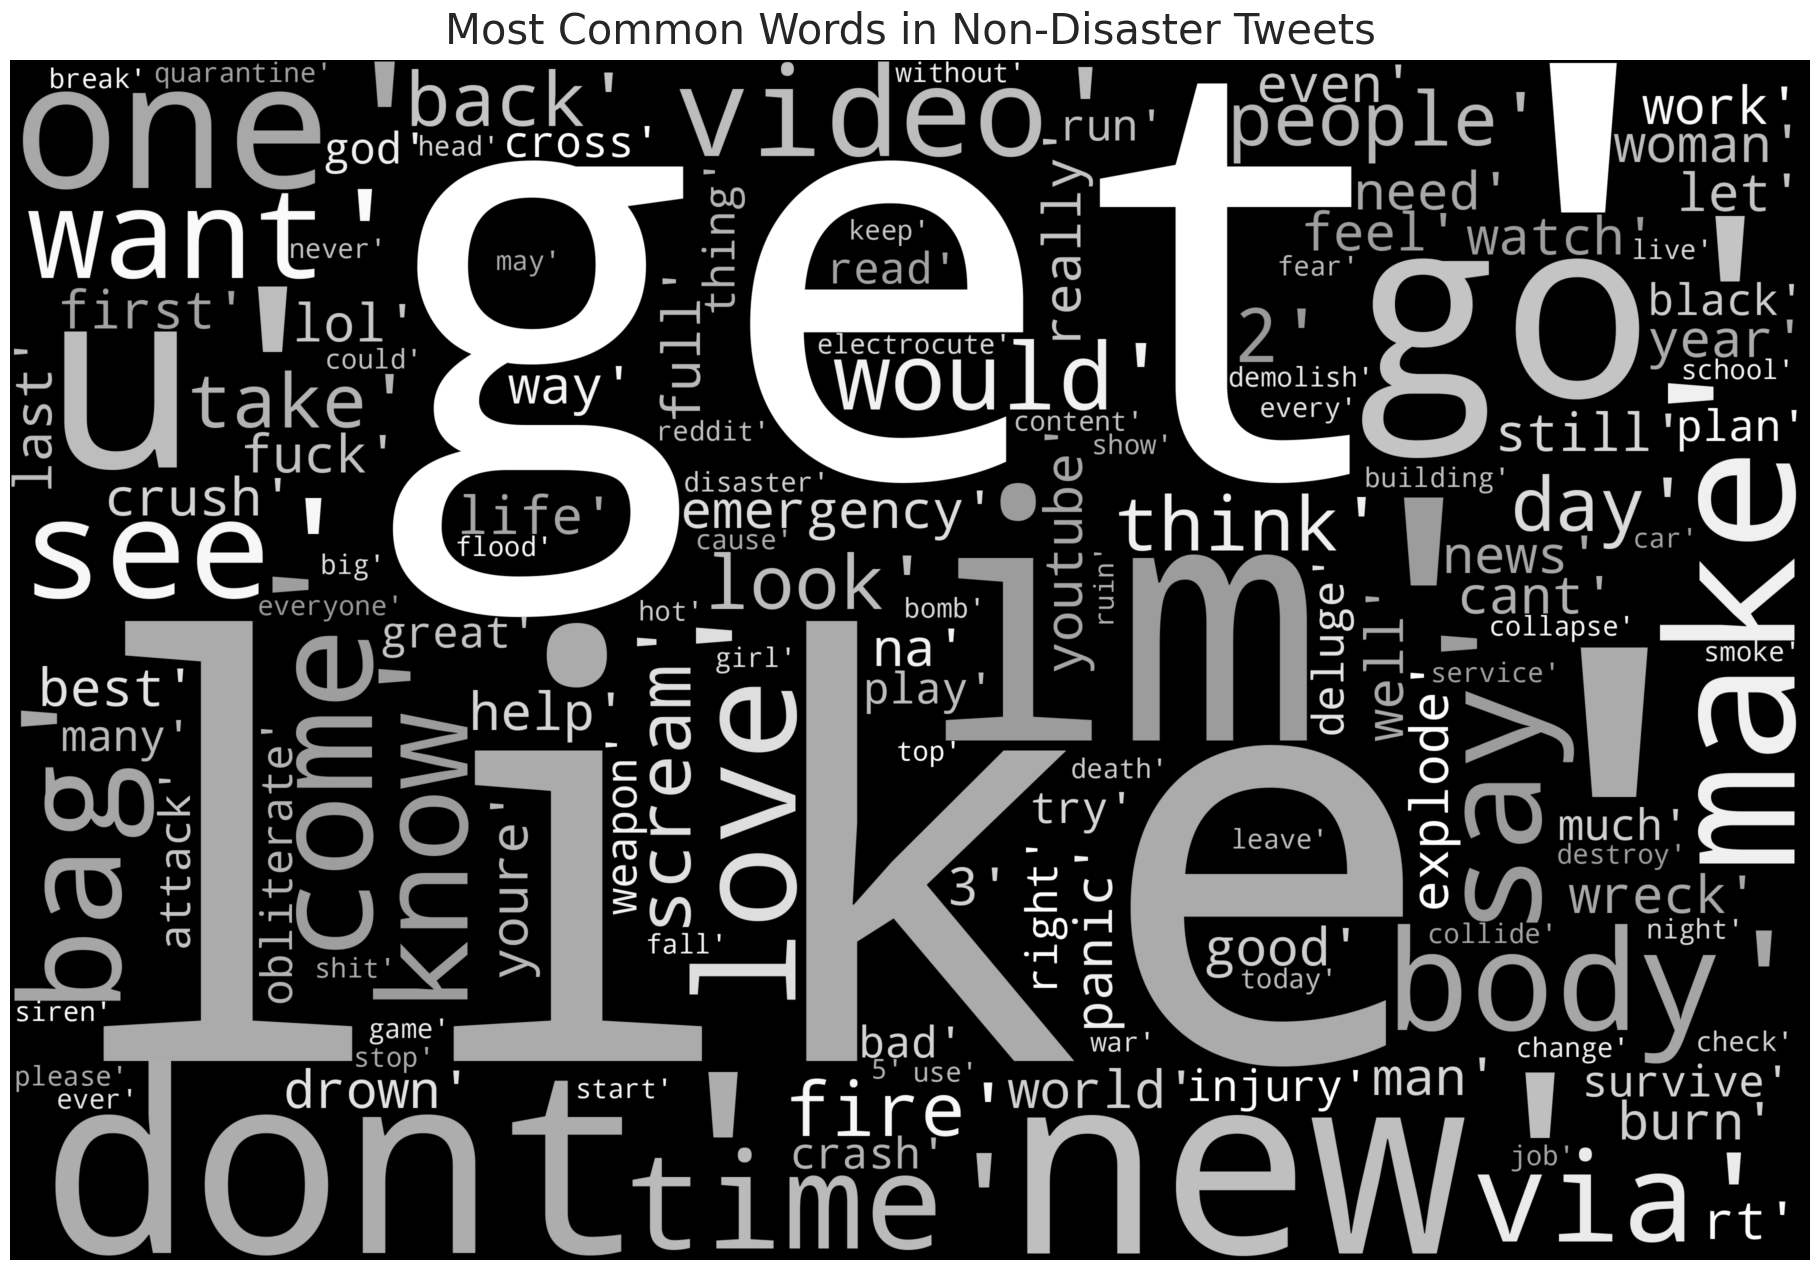

In [ ]:
plot_wordcloud(trainv[trainv['target'] == 0]['lemmatized'],
               'Most Common Words in Non-Disaster Tweets',
               title_size=30)

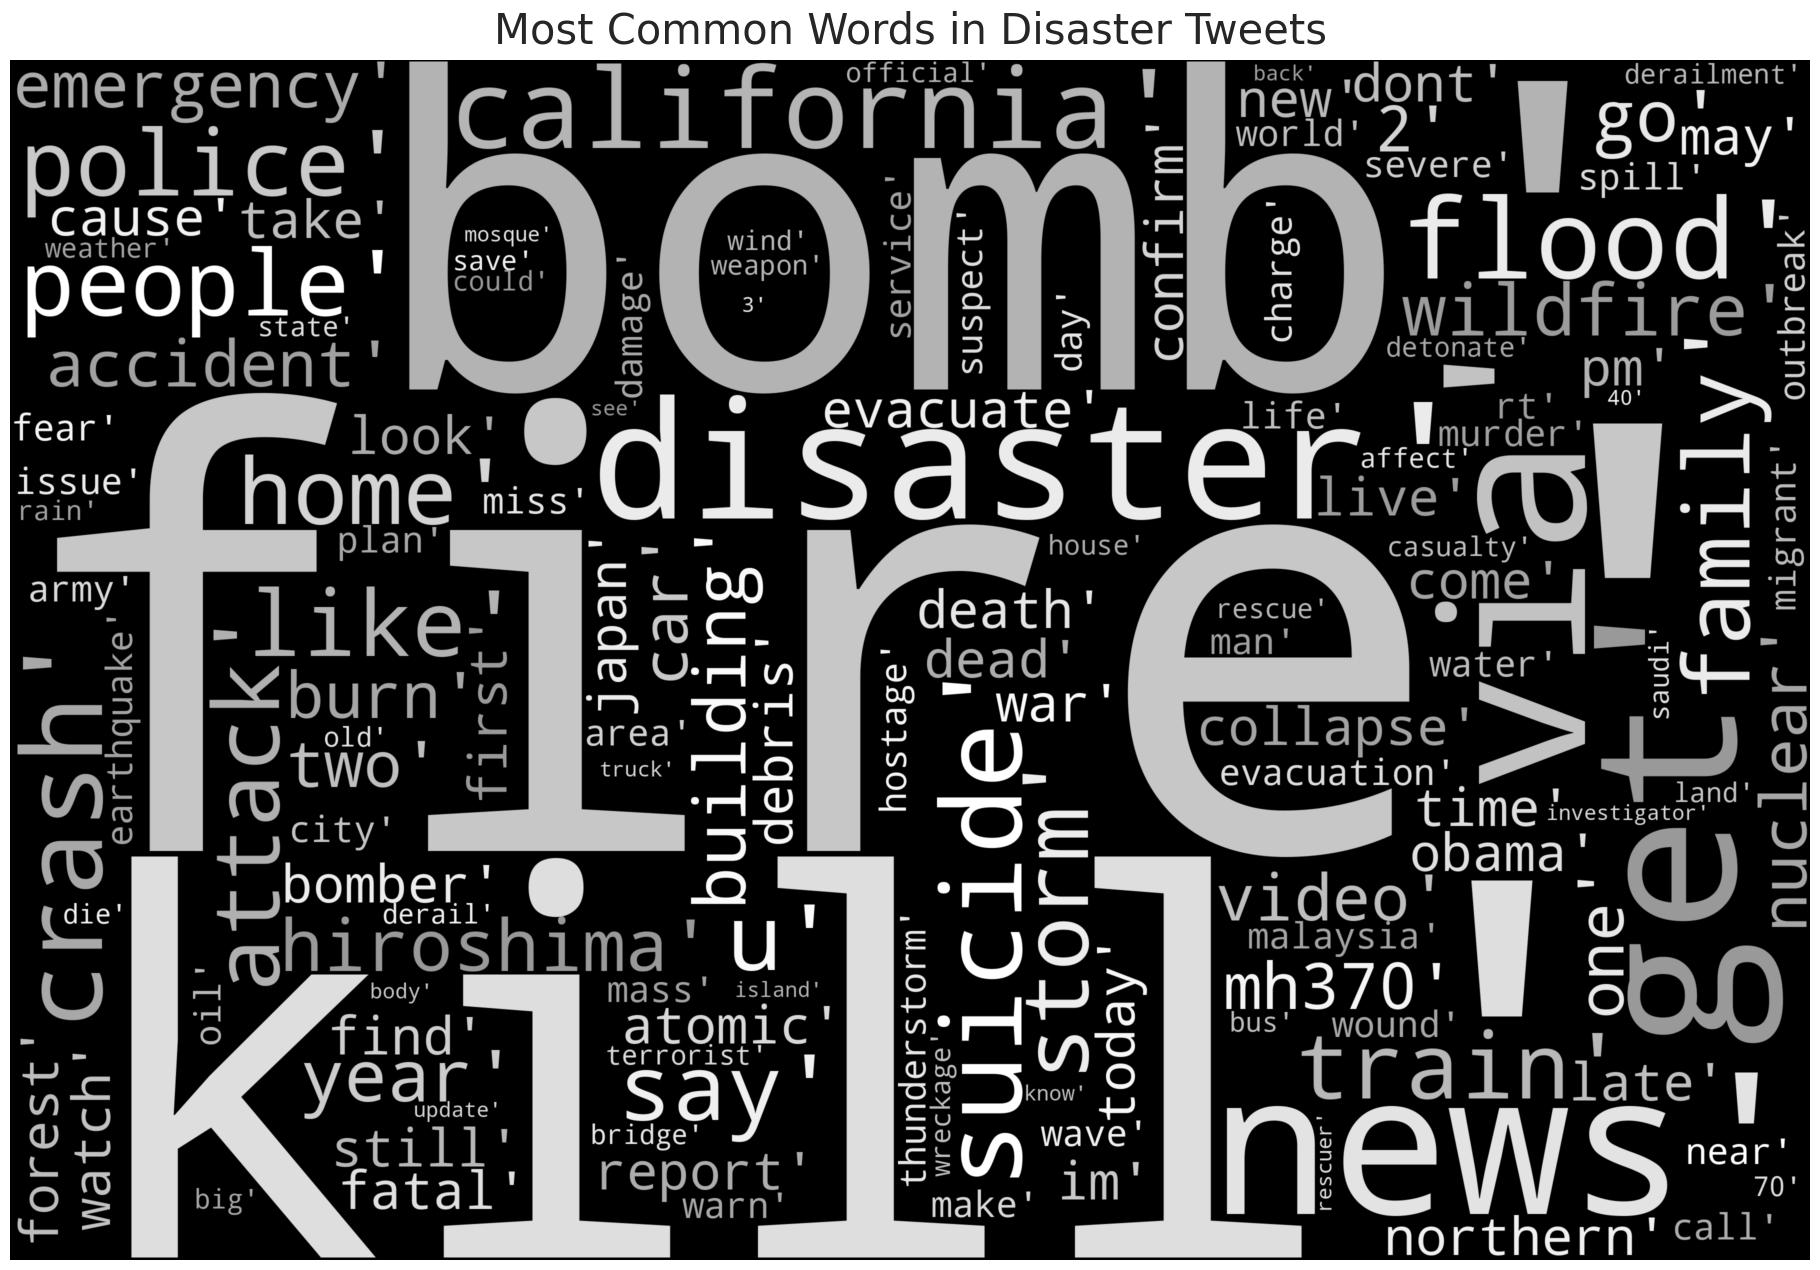

In [ ]:
plot_wordcloud(trainv[trainv['target'] == 1]['lemmatized'],
               'Most Common Words in Disaster Tweets',
               title_size=30)


## Named Entity Recognition


In [ ]:
# # Step 1: Install spaCy and the en_core_web_sm model
# !pip install spacy
# !python -m spacy download en_core_web_sm

# # Step 2: Import spaCy and load the model
# import spacy

# # Load the NER model
# nlp = spacy.load('en_core_web_sm')


In [ ]:
def plot_named_entity_barchart(text):

    """A function for extracting named entities and comparing them"""

    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)


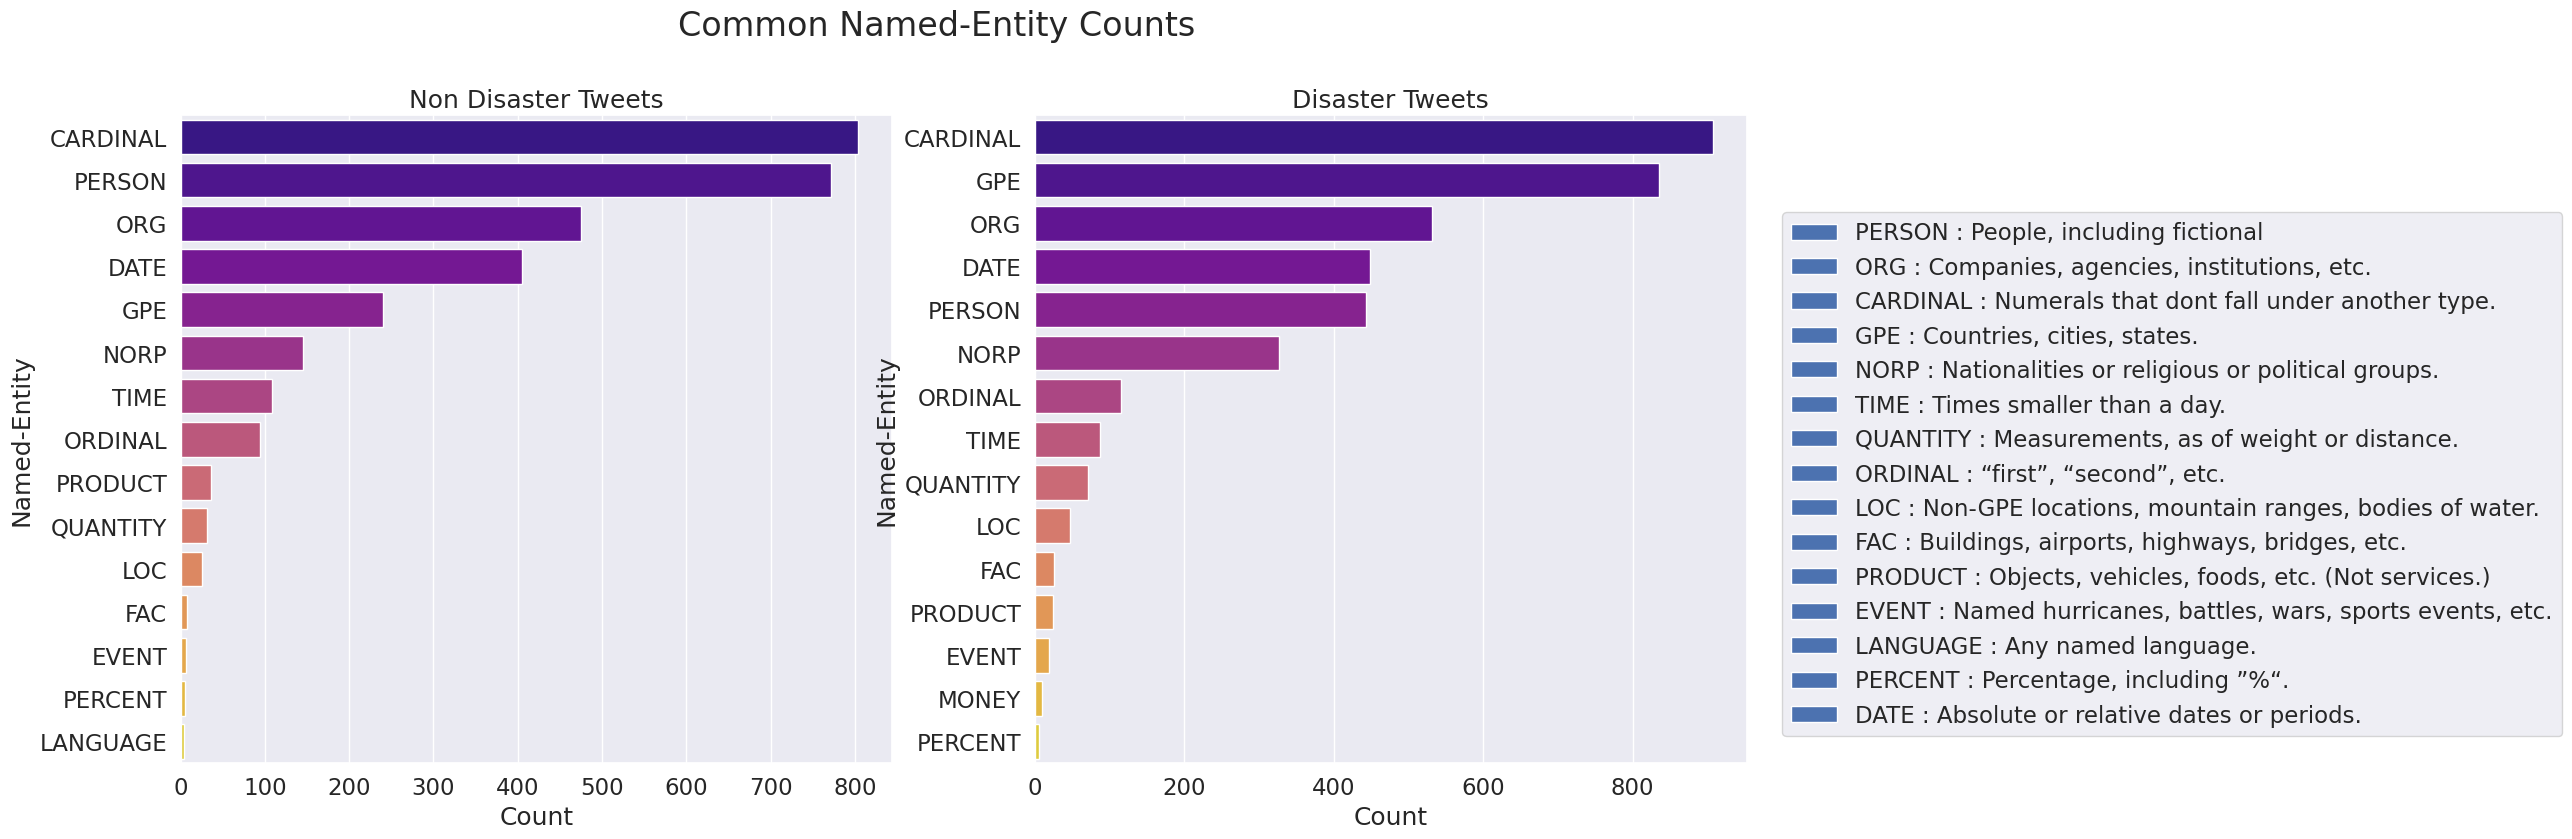

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

# Model Training

In [ ]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
    print(f'There are {len(tf.config.list_physical_devices("GPU"))} GPU(s) available.')
    print(f'We will use the GPU: {device_name}')
else:
    print('No GPU available, using the CPU instead.')

# Set device
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'


There are 1 GPU(s) available.
We will use the GPU: /device:GPU:0


In [ ]:
# Loading the data for modelling.

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

display(train.sample(10))


Number of training tweets: 7613

Number of training tweets: 3263



,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


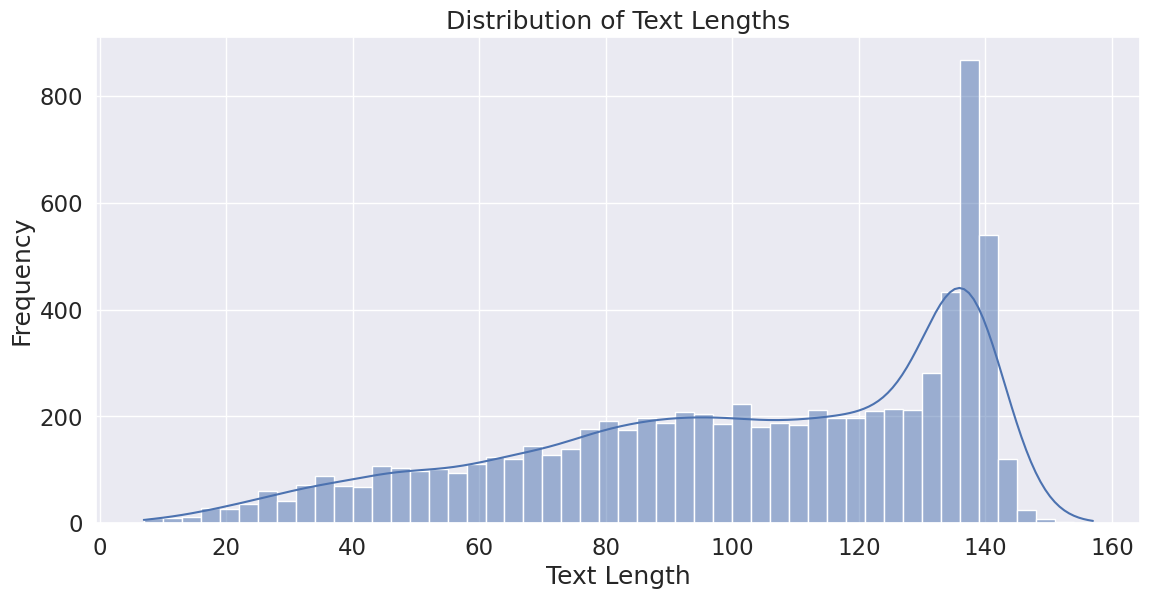

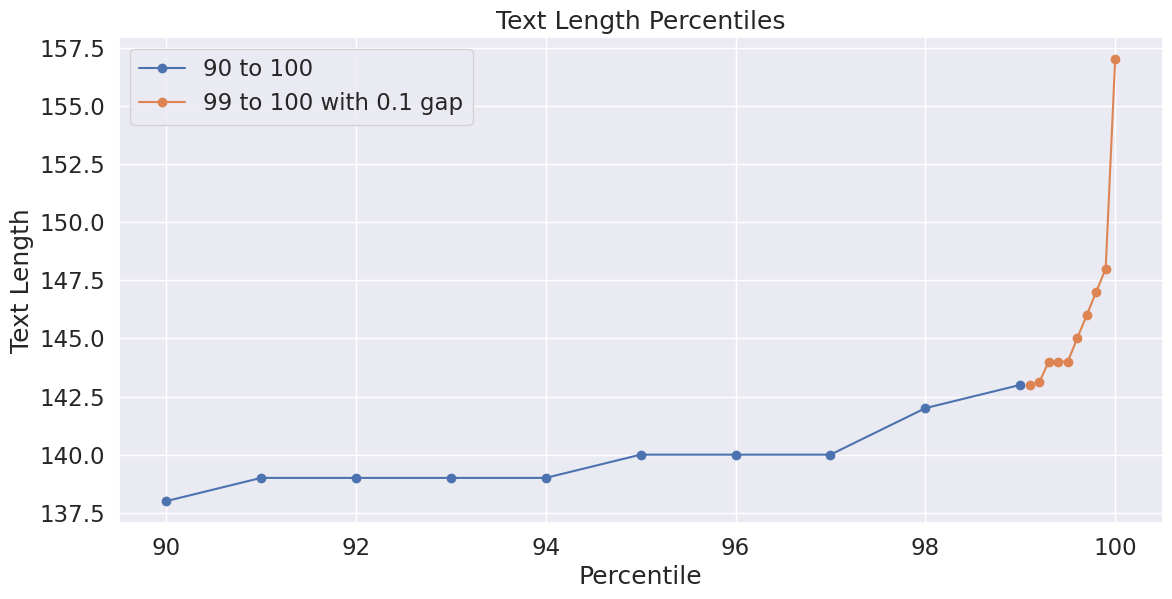

,Percentile,Text Length
0,90.0,138.000
1,91.0,139.000
2,92.0,139.000
3,93.0,139.000
4,94.0,139.000
5,95.0,140.000
6,96.0,140.000
7,97.0,140.000
8,98.0,142.000
9,99.0,143.000


In [ ]:
# Calculate text lengths
train['text_length'] = train['text'].apply(len)

# Plot distribution of text lengths
plt.figure(figsize=(12, 6))
sns.histplot(train['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Calculate percentiles
percentiles = list(range(90, 100)) + [99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]
length_percentiles = [np.percentile(train['text_length'], p) for p in percentiles]

# Plot percentiles
plt.figure(figsize=(12, 6))
plt.plot(percentiles[:10], length_percentiles[:10], marker='o', label='90 to 100')
plt.plot(percentiles[10:], length_percentiles[10:], marker='o', label='99 to 100 with 0.1 gap')
plt.title('Text Length Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Text Length')
plt.legend()
plt.grid(True)
plt.show()

# Display percentile values for better decision making
percentile_data = pd.DataFrame({
    'Percentile': percentiles,
    'Text Length': length_percentiles
})
display(percentile_data)

In [ ]:
# Calculate 99.9th percentile length
max_length = np.percentile(train['text_length'], 99.9)
print(f'99.9th percentile length: {max_length}')


99.9th percentile length: 148.0


In [ ]:
train['text'].shape,test['text'].shape

((7613,), (3263,))

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

# Tokenize the data
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding='max_length', max_length=int(max_length))
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding='max_length', max_length=int(max_length))

# Convert the encodings to arrays and check shapes
input_ids = np.array(train_encodings['input_ids'])
token_type_ids = np.array(train_encodings['token_type_ids'])
attention_mask = np.array(train_encodings['attention_mask'])

print(input_ids.shape)
print(token_type_ids.shape)
print(attention_mask.shape)

(7613, 148)
(7613, 148)
(7613, 148)


In [ ]:
# Convert the encodings to TensorFlow datasets with a smaller batch size
batch_size = 16  # Adjust this as needed to fit your GPU memory

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train['target'].values
)).shuffle(len(train)).batch(batch_size)

# Ensure that train_dataset is not empty
assert len(list(train_dataset)) > 0, "Training dataset is empty!"

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train['target'].values
)).skip(int(0.8 * len(train))).batch(batch_size)

# Ensure that val_dataset is not empty
assert len(list(val_dataset)) > 0, "Validation dataset is empty!"

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings)
)).batch(batch_size)

# Ensure that test_dataset is not empty
assert len(list(test_dataset)) > 0, "Test dataset is empty!"

In [ ]:
#!pip install tensorflow_addons

In [ ]:
#!pip install transformers==4.37.2

In [ ]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the model
model = TFBertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-6, epsilon=1e-8)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# # Define callbacks for saving the best model and early stopping
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import f1_score

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        val_true = []
        val_pred = []

        for x, y in self.val_data:
            val_true.extend(y.numpy())
            predictions = self.model.predict(x)
            val_pred.extend(np.argmax(predictions.logits, axis=1))

        val_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f' - val_f1: {val_f1:.4f}')


In [ ]:
# Define callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, mode='min', save_format='tf')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')

# Train the model with a smaller batch size
epochs = 3
f1_callback = F1ScoreCallback(val_dataset)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, callbacks=[checkpoint, early_stopping, f1_callback])



Epoch 1/3
1/1 [==============================] - 0s 76ms/step
 - val_f1: 0.8694
476/476 [==============================] - 558s 998ms/step - loss: 0.4842 - accuracy: 0.7848 - val_loss: 0.3440 - val_accuracy: 0.8693
Epoch 2/3
1/1 [==============================] - 0s 79ms/step
 - val_f1: 0.9023
476/476 [==============================] - 465s 978ms/step - loss: 0.3740 - accuracy: 0.8496 - val_loss: 0.2778 - val_accuracy: 0.9028
Epoch 3/3
1/1 [==============================] - 0s 78ms/step
 - val_f1: 0.9223
476/476 [==============================] - 463s 974ms/step - loss: 0.3281 - accuracy: 0.8730 - val_loss: 0.2265 - val_accuracy: 0.9225


In [ ]:
# Save the model and tokenizer
model.save_weights('path_to_save_model.h5')
tokenizer.save_pretrained('path_to_save_tokenizer')

('path_to_save_tokenizer/tokenizer_config.json',
 'path_to_save_tokenizer/special_tokens_map.json',
 'path_to_save_tokenizer/vocab.txt',
 'path_to_save_tokenizer/added_tokens.json')

## Plot Metrics

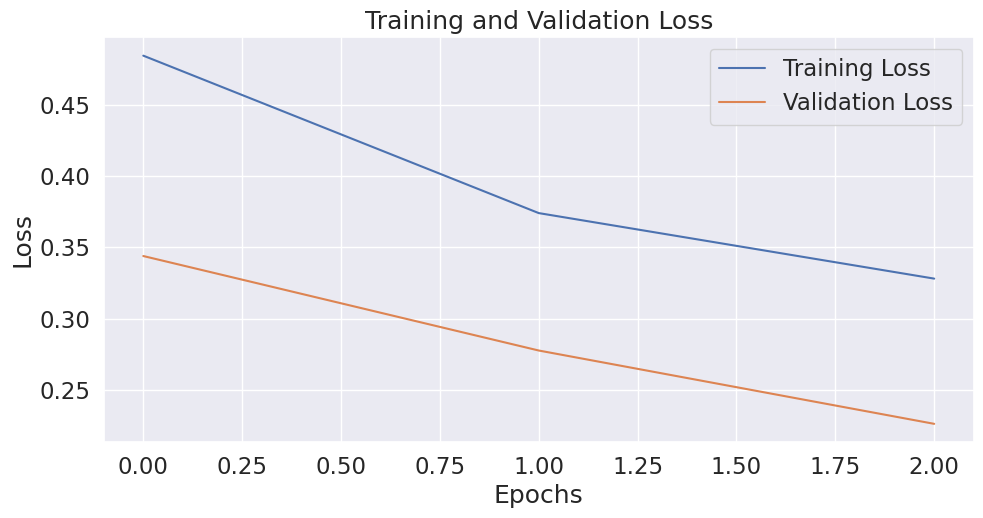

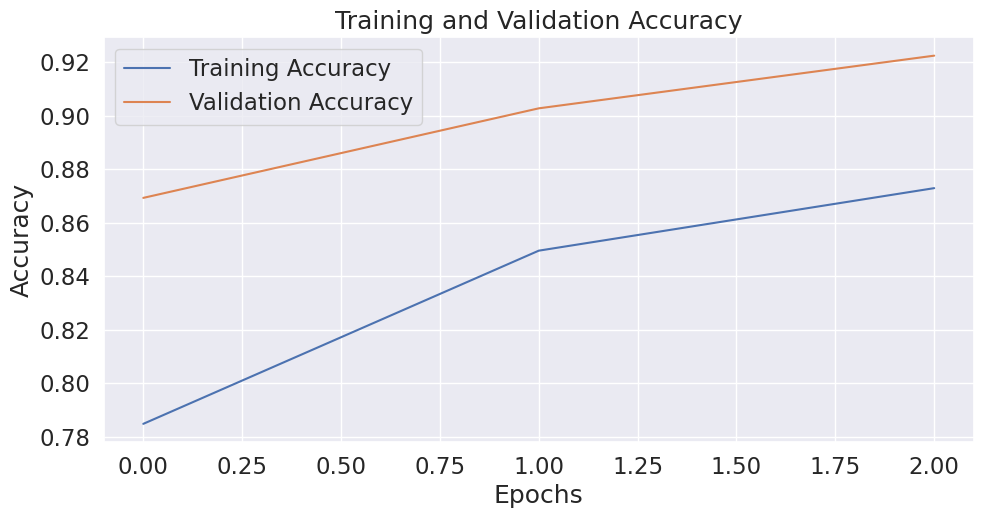

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Load the best model
model = TFBertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)
model.load_weights('path_to_save_model.h5')

# Predict on the validation set
val_predictions = model.predict(val_dataset).logits
val_predicted_labels = tf.argmax(val_predictions, axis=1).numpy()
val_true_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Calculate F1 Score
val_f1_score = f1_score(val_true_labels, val_predicted_labels, average='weighted')
print(f'Validation F1 Score: {val_f1_score}')


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


96/96 [==============================] - 28s 234ms/step
Validation F1 Score: 0.9223002347266578


## inference

In [ ]:
def predict(texts):
    # Tokenize the texts
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings)
    )).batch(32)

    # Predict
    predictions = model.predict(dataset).logits
    predicted_labels = tf.argmax(predictions, axis=1).numpy()
    return predicted_labels

# Example inference
sample_texts = test['text'].tolist()[:5]  # Taking first 5 samples for demonstration
predicted_labels = predict(sample_texts)
for text, label in zip(sample_texts, predicted_labels):
    print(f'Text: {text}\nPredicted Label: {label}\n')


1/1 [==============================] - 6s 6s/step
Text: Just happened a terrible car crash
Predicted Label: 1

Text: Heard about #earthquake is different cities, stay safe everyone.
Predicted Label: 1

Text: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Predicted Label: 1

Text: Apocalypse lighting. #Spokane #wildfires
Predicted Label: 1

Text: Typhoon Soudelor kills 28 in China and Taiwan
Predicted Label: 1



## Load and Continue Training the Model

In [ ]:
# Load the model and continue training
model = TFBertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)
model.load_weights('path_to_save_model.h5')

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-6, epsilon=1e-8)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Continue training
history = model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[checkpoint, early_stopping, f1_callback])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1/1 [==============================] - 0s 77ms/step
 - val_f1: 0.9466
476/476 [==============================] - 560s 1s/step - loss: 0.2901 - accuracy: 0.8916 - val_loss: 0.1819 - val_accuracy: 0.9468
Epoch 2/2
1/1 [==============================] - 0s 78ms/step
 - val_f1: 0.9479
476/476 [==============================] - 462s 972ms/step - loss: 0.2353 - accuracy: 0.9182 - val_loss: 0.1519 - val_accuracy: 0.9481
